In [3]:
using PyPlot

INFO: Precompiling module PyPlot.


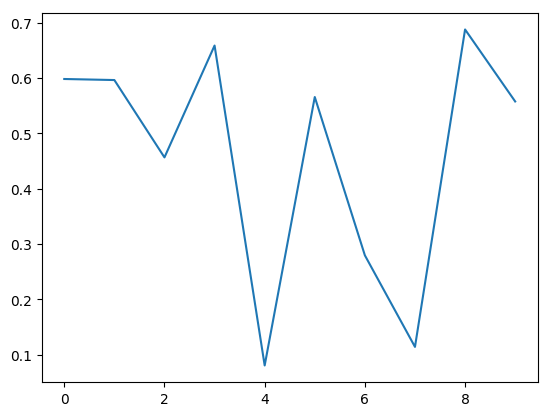

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x131dd7fd0>

In [4]:
plot(rand(10))